# Biaxial-strained antisites

In [1]:
from pymatgen.io.vasp.inputs import Structure
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use(['science', 'notebook', 'grid'])


from qubitPack.tool_box import get_db

save_path = "/Users/jeng-yuantsai/Research/project/qubit_sensor/xls"

In [2]:
def get_st(st, bottom=24, NN=None):
    data = []
    for st in [st]:
        if not NN:
            NN = e["NN"]
        print(np.round(np.array(st.lattice.abc)/5, 4).tolist())
        print(np.around(np.array([st.get_distance(NN[-1], x) for x in NN+[bottom] ]), 4))
        d = dict(
            zip(
                ["d1", "d2", "d3", "d4", "z1", "z2", "z3", "z4", "a", "b", "c"],
                np.around(
                    np.array(
                        [st.get_distance(NN[-1], x) for x in NN[:-1]+[bottom] ]+
                        [st.sites[NN[-1]].coords[-1] - st.sites[x].coords[-1] for x in NN[:-1]+[bottom]]+
                        np.round(np.array(st.lattice.abc)/5, 4).tolist()
                    ), 3
                )
            )
        )
        data.append(d)
    return data

## Unstrained ZFS 

In [3]:
zfs0_db = get_db("single_photon_emitter", "zfs")
Ds = []
es = zfs0_db.collection.find({"task_id": {"$in": [758, 759, 760, 761, 815]}})
for e in es:
    data = {}
    formula = "".join(e["formula"].split(" "))
    D = e["pyzfs_out"]["D"]/1000
    E = e["pyzfs_out"]["E"]/1000
    strain_ratio = 0
    taskid = e["task_id"]
    data.update({"taskid": taskid, "formula": formula, "D": D, "E":E, "strain_ratio": strain_ratio})
    Ds.append(data)
zfs0_df = pd.DataFrame(Ds)
display(zfs0_df)

,taskid,formula,D,E,strain_ratio
0,758,W26Se49,6.807135,-0.000230,0
1,759,Mo26Se49,7.218477,-0.001220,0
2,760,W26S49,7.885142,-0.002513,0
3,761,Mo26S49,8.405764,-0.000181,0
4,815,W26S49,6.603212,-1.247016,0


## Unstrained structure

In [4]:
st0_df = []
es = zfs0_db.collection.find({"task_id": {"$in": [758, 759, 760, 761, 815]}})
for e in es:
    st = Structure.from_dict(e["structure"])
    formula = "".join(e["formula"].split(" "))
    if "Te" in formula:
        bottom = 50
        nn = [54, 49, 55, 74]

    else:
        bottom = 24
        nn = [5, 6, 0, 25]

    st0 = get_st(st, bottom=bottom, NN=nn)
    st0[0].update(
        {
            "taskid": e["task_id"],
            "formula": formula,
            "strain_ratio": 0
        }
    )
    st0_df.extend(st0)
st0_df = pd.DataFrame(st0_df)
display(st0_df)

[3.2755, 3.2755, 4.6622]
[2.6148 2.6148 2.6148 0.     5.289 ]
[3.2782, 3.2782, 4.6599]
[2.6554 2.6553 2.6553 0.     5.3026]
[3.1474, 3.1474, 4.6213]
[2.6327 2.6327 2.6327 0.     5.1305]
[3.1469, 3.1469, 4.6181]
[2.6691 2.6691 2.6691 0.     5.1384]
[3.1474, 3.1474, 4.6213]
[2.5371 2.7018 2.6885 0.     5.1787]


,d1,d2,d3,d4,z1,z2,z3,z4,a,b,c,taskid,formula,strain_ratio
0,2.615,2.615,2.615,5.289,1.868,1.868,1.868,1.766,3.276,3.276,4.662,758,W26Se49,0
1,2.655,2.655,2.655,5.303,1.926,1.926,1.926,1.806,3.278,3.278,4.660,759,Mo26Se49,0
2,2.633,2.633,2.633,5.131,1.932,1.932,1.932,1.826,3.147,3.147,4.621,760,W26S49,0
3,2.669,2.669,2.669,5.138,1.985,1.985,1.985,1.858,3.147,3.147,4.618,761,Mo26S49,0
4,2.537,2.702,2.689,5.179,1.992,1.901,1.903,1.827,3.147,3.147,4.621,815,W26S49,0


## ZFSs & Structures

In [5]:
biaxial_db = get_db("qubit_sensor", "monolayer_biaxial")
zfs_db = get_db("qubit_sensor", "zfs")
zfs0_D = zfs0_df.loc[zfs0_df["taskid"] == 760, "D"].iloc[0]

In [6]:
zfs_data = []
st_data = []
for e in zfs_db.collection.find():
    prev_fw_id = e["prev_fw_taskid"]
    prev_entry = biaxial_db.collection.find_one({"task_id": prev_fw_id})
    strain_ratio = prev_entry["perturbed"]["biaxial_ratio"]
    info = {
        "zfs_taskid": e["task_id"],
        "scf_taskid": e["prev_fw_taskid"],
        "formula": prev_entry["formula_pretty"],
        "strain_ratio": (strain_ratio - 1)*100, 
        "D": e["pyzfs_out"]["D"]*0.001,
        "E": e["pyzfs_out"]["E"]*0.001,
        "dD": e["pyzfs_out"]["D"]*0.001 - zfs0_D,
        "dD_in_percent": (e["pyzfs_out"]["D"]*0.001 - zfs0_D)/zfs0_D*100,
        "NN": prev_entry["NN"]
    }
    st = Structure.from_dict(prev_entry["output"]["structure"])
    if "Te" in info["formula"]:
        bottom = 50
    else:
        bottom = 24
    st_info = get_st(st, bottom=bottom, NN=info["NN"])
    print(info["NN"])
    st_info[0].update(
        {
            "zfs_taskid": e["task_id"],
            "scf_taskid": e["prev_fw_taskid"],
            "formula": prev_entry["formula_pretty"],
            "strain_ratio": (strain_ratio - 1)*100
        }
    )
    zfs_data.append(info)
    st_data.extend(st_info)

[3.2261, 3.2261, 4.6369]
[2.6316 2.6316 2.6316 0.     5.2346]
[5, 6, 0, 25]
[3.0688, 3.0688, 4.6058]
[2.6332 2.6332 2.6332 0.     5.0263]
[5, 6, 0, 25]
[3.3048, 3.3048, 4.6524]
[2.6276 2.6276 2.6276 0.     5.336 ]
[5, 6, 0, 25]
[3.1117, 3.1117, 4.6291]
[2.6235 2.6235 2.6235 0.     5.0728]
[5, 6, 0, 25]
[3.3294, 3.3294, 4.6798]
[2.5335 2.5335 2.5335 0.     4.1635]
[54, 49, 55, 74]
[3.417, 3.417, 4.6977]
[2.5386 2.5386 2.5386 0.     4.2183]
[54, 49, 55, 74]
[3.1936, 3.1936, 4.6456]
[2.6204 2.6204 2.6204 0.     5.1816]
[5, 6, 0, 25]
[3.5922, 3.5922, 4.7334]
[2.5767 2.5766 2.5766 0.     4.2617]
[54, 49, 55, 74]
[3.3573, 3.3573, 4.6787]
[2.5747 2.5747 2.5747 0.     5.366 ]
[5, 6, 0, 25]
[3.4392, 3.4392, 4.6953]
[2.5746 2.5746 2.5746 0.     5.4596]
[5, 6, 0, 25]
[3.6798, 3.6798, 4.7513]
[2.5185 2.5184 2.5184 0.     4.4386]
[54, 49, 55, 74]
[3.0682, 3.0682, 4.6026]
[2.6598 2.6598 2.6598 0.     5.0327]
[5, 6, 0, 25]
[3.1962, 3.1962, 4.6434]
[2.6518 2.6518 2.6518 0.     5.1949]
[5, 6, 0, 25]
[3

### ZFS info

In [7]:
zfs_df = pd.DataFrame(zfs_data)
display(zfs_df.round(2))

,zfs_taskid,scf_taskid,formula,strain_ratio,D,E,dD,dD_in_percent,NN
0,5,3,W26S49,2.5,7.24,-0.00,-0.65,-8.18,"[5, 6, 0, 25]"
1,6,4,W26S49,-2.5,8.17,-0.00,0.28,3.58,"[5, 6, 0, 25]"
2,8,7,W26S49,5.0,6.41,-0.00,-1.48,-18.77,"[5, 6, 0, 25]"
3,17,14,W26Se49,-5.0,6.33,-0.00,-1.56,-19.74,"[5, 6, 0, 25]"
4,18,13,Te49W26,-5.0,0.81,-0.22,-7.07,-89.68,"[54, 49, 55, 74]"
5,19,15,Te49W26,-2.5,-0.97,0.23,-8.86,-112.36,"[54, 49, 55, 74]"
6,20,16,W26Se49,-2.5,6.83,-0.00,-1.05,-13.35,"[5, 6, 0, 25]"
7,23,22,Te49W26,2.5,2.14,-0.60,-5.75,-72.88,"[54, 49, 55, 74]"
8,27,25,W26Se49,2.5,-1.40,0.46,-9.29,-117.77,"[5, 6, 0, 25]"
9,29,28,W26Se49,5.0,2.47,-0.36,-5.42,-68.68,"[5, 6, 0, 25]"


#### ZFS plotting 

W26S49


,zfs_taskid,scf_taskid,formula,strain_ratio,D,E,dD,dD_in_percent,NN,taskid
1,6.0,4.0,W26S49,-2.5,8.17,-0.0,0.28,3.58,"[5, 6, 0, 25]",NaN
2,NaN,NaN,W26S49,0.0,7.89,-0.0,NaN,NaN,NaN,760.0
0,5.0,3.0,W26S49,2.5,7.24,-0.0,-0.65,-8.18,"[5, 6, 0, 25]",NaN
2,8.0,7.0,W26S49,5.0,6.41,-0.0,-1.48,-18.77,"[5, 6, 0, 25]",NaN


W26Se49


,zfs_taskid,scf_taskid,formula,strain_ratio,D,E,dD,dD_in_percent,NN,taskid
3,17.0,14.0,W26Se49,-5.0,6.33,-0.00,-1.56,-19.74,"[5, 6, 0, 25]",NaN
6,20.0,16.0,W26Se49,-2.5,6.83,-0.00,-1.05,-13.35,"[5, 6, 0, 25]",NaN
0,NaN,NaN,W26Se49,0.0,6.81,-0.00,NaN,NaN,NaN,758.0
8,27.0,25.0,W26Se49,2.5,-1.40,0.46,-9.29,-117.77,"[5, 6, 0, 25]",NaN
9,29.0,28.0,W26Se49,5.0,2.47,-0.36,-5.42,-68.68,"[5, 6, 0, 25]",NaN


Te49W26


,zfs_taskid,scf_taskid,formula,strain_ratio,D,E,dD,dD_in_percent,NN,taskid
4,18.0,13.0,Te49W26,-5.0,0.81,-0.22,-7.07,-89.68,"[54, 49, 55, 74]",NaN
5,19.0,15.0,Te49W26,-2.5,-0.97,0.23,-8.86,-112.36,"[54, 49, 55, 74]",NaN
7,23.0,22.0,Te49W26,2.5,2.14,-0.60,-5.75,-72.88,"[54, 49, 55, 74]",NaN
10,35.0,32.0,Te49W26,5.0,0.77,-0.00,-7.11,-90.23,"[54, 49, 55, 74]",NaN


Mo26S49


,zfs_taskid,scf_taskid,formula,strain_ratio,D,E,dD,dD_in_percent,NN,taskid
14,44.0,41.0,Mo26S49,-5.0,7.99,-0.0,0.10,1.28,"[5, 6, 0, 25]",NaN
11,38.0,37.0,Mo26S49,-2.5,8.37,-0.0,0.49,6.20,"[5, 6, 0, 25]",NaN
3,NaN,NaN,Mo26S49,0.0,8.41,-0.0,NaN,NaN,NaN,761.0
15,47.0,46.0,Mo26S49,2.5,8.11,-0.0,0.23,2.88,"[5, 6, 0, 25]",NaN
16,50.0,49.0,Mo26S49,5.0,7.07,-0.0,-0.81,-10.30,"[5, 6, 0, 25]",NaN


Mo26Se49


,zfs_taskid,scf_taskid,formula,strain_ratio,D,E,dD,dD_in_percent,NN,taskid
13,43.0,40.0,Mo26Se49,-5.0,6.62,-0.00,-1.27,-16.10,"[5, 6, 0, 25]",NaN
12,42.0,39.0,Mo26Se49,-2.5,7.26,-0.00,-0.62,-7.92,"[5, 6, 0, 25]",NaN
1,NaN,NaN,Mo26Se49,0.0,7.22,-0.00,NaN,NaN,NaN,759.0
17,53.0,52.0,Mo26Se49,2.5,6.99,-0.01,-0.90,-11.35,"[5, 6, 0, 25]",NaN


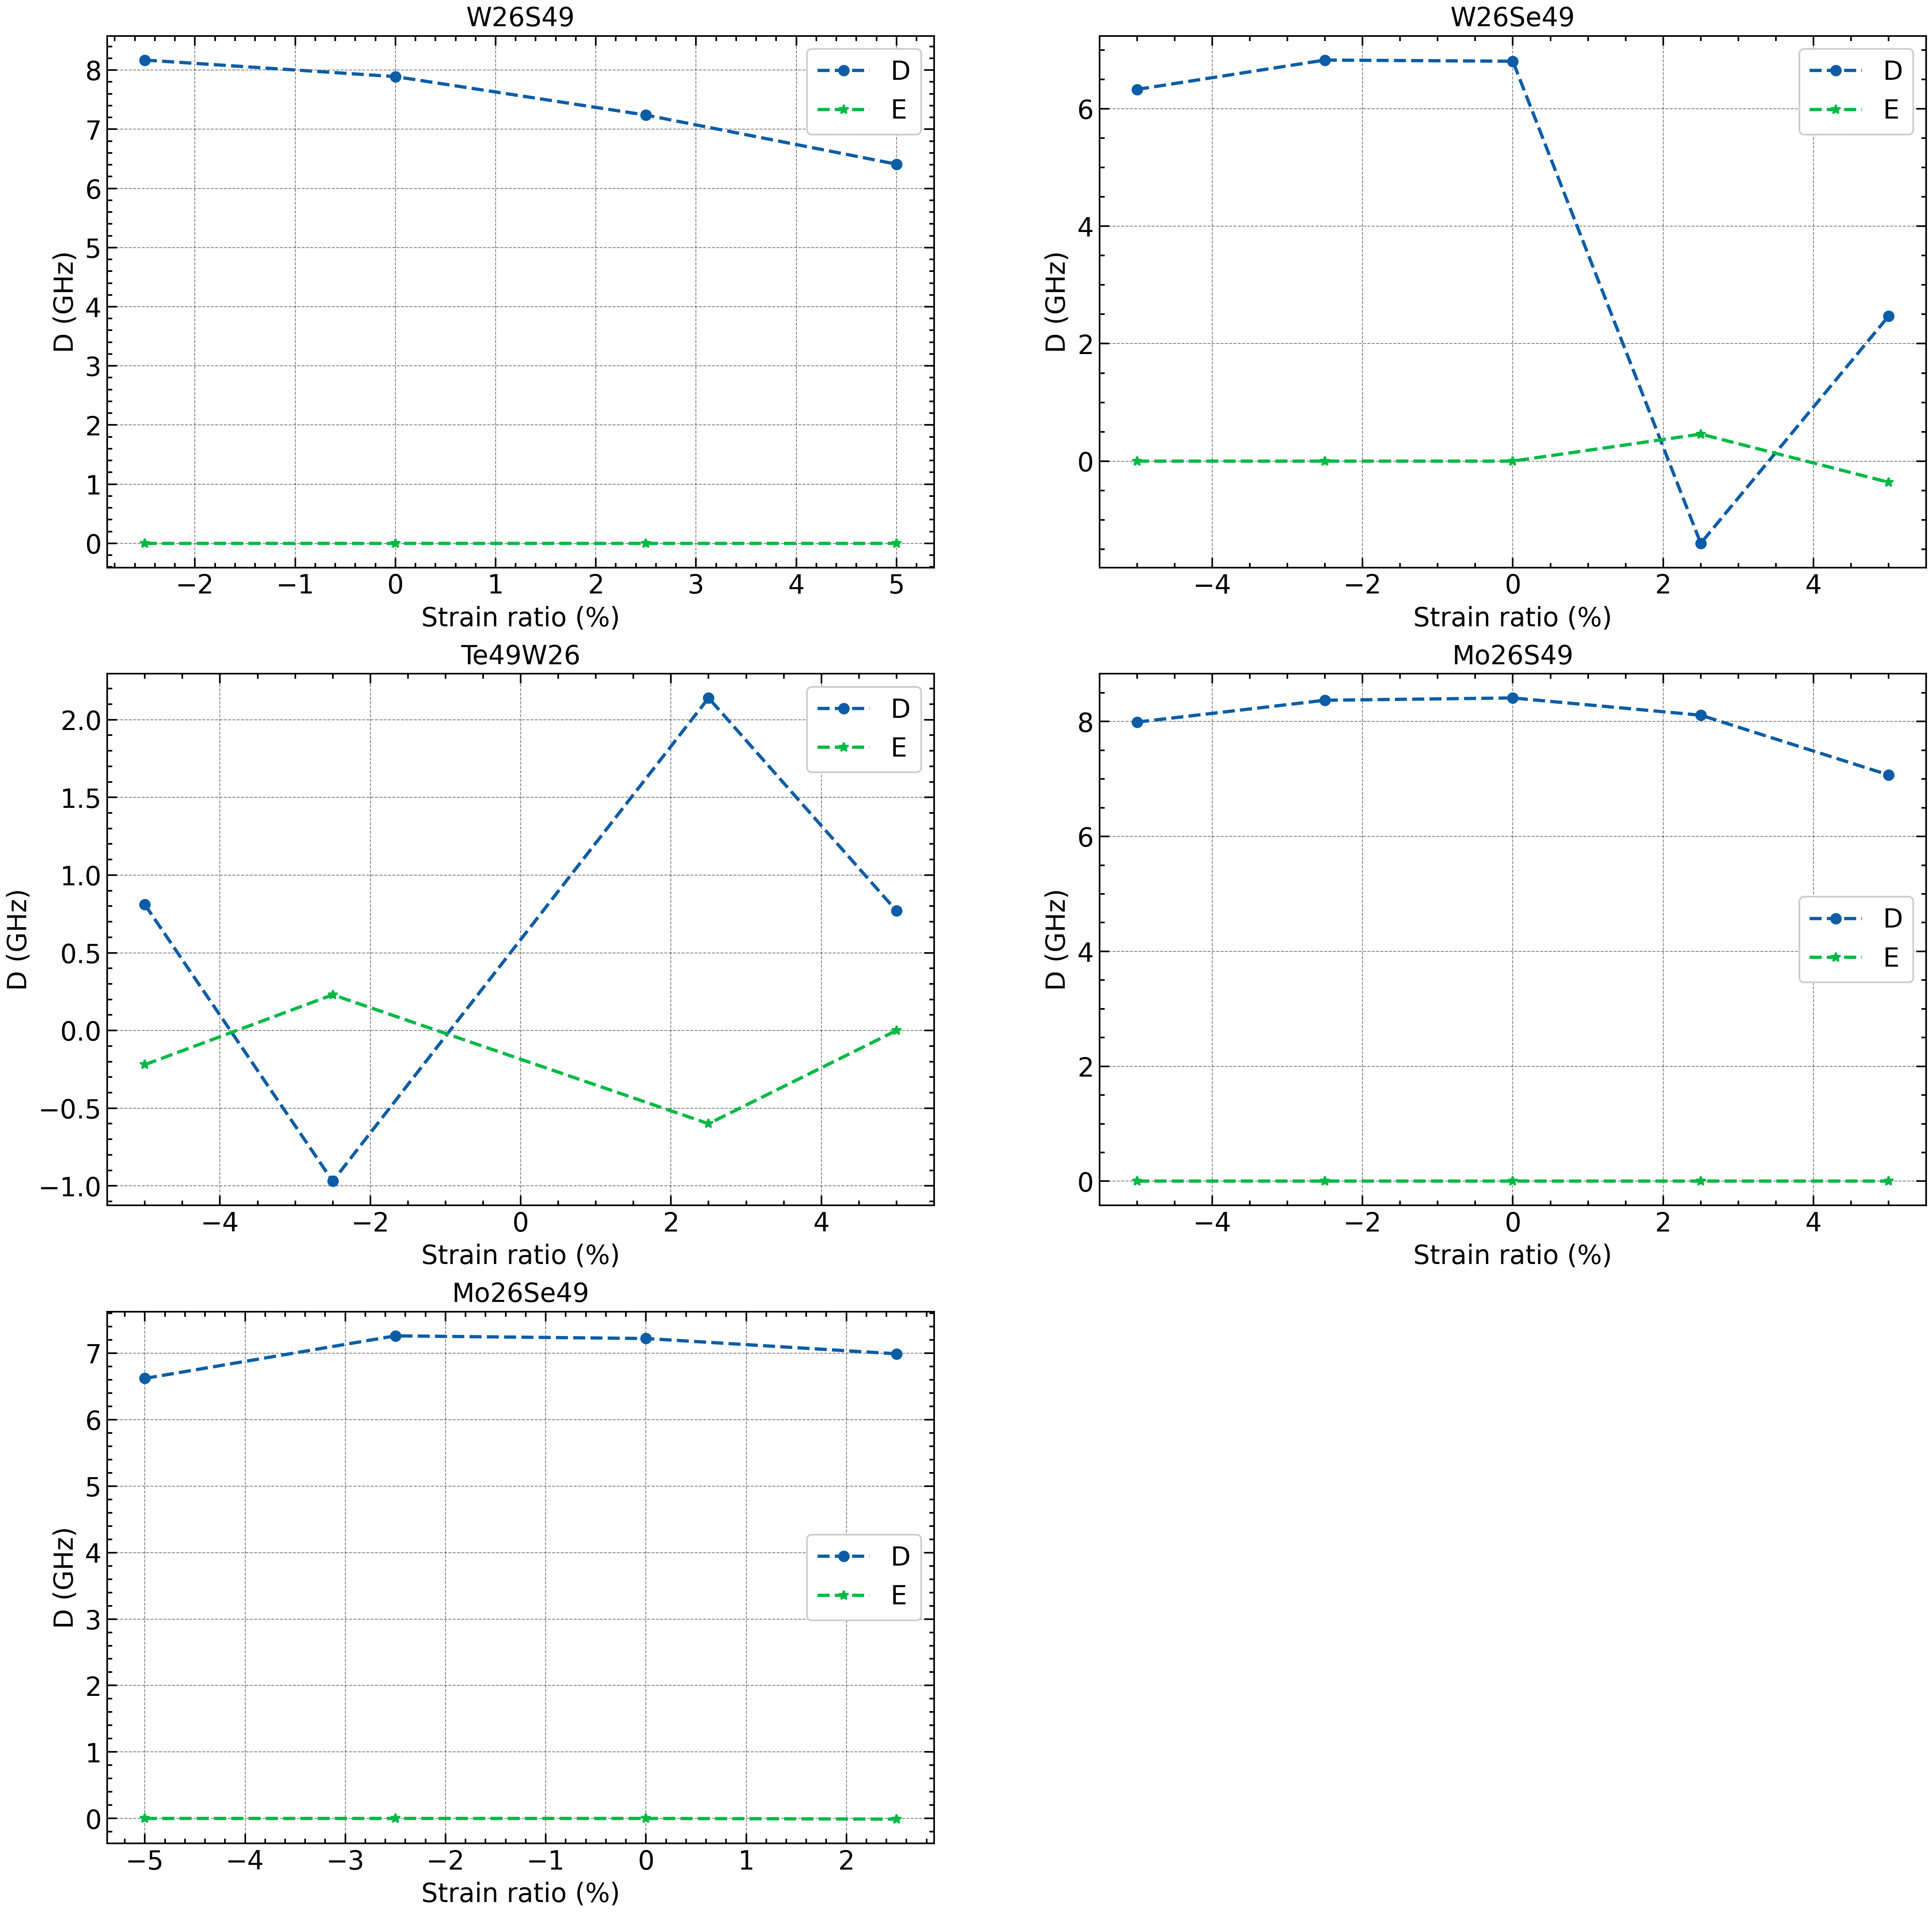

In [8]:
fig = plt.figure(dpi=300, figsize=(20, 20))
# fig.subplots_adjust(hspace=1, wspace=0.4)

for plt_idx, formula in enumerate(zfs_df["formula"].unique()):
    print(formula)
    zfs = zfs_df.loc[zfs_df["formula"] == formula, :]
    zfs0_condition = (zfs0_df["formula"].str.contains(formula)) & (zfs0_df["taskid"] != 815)
    zfs = zfs.append(zfs0_df.loc[zfs0_condition, :]).round(2).sort_values("strain_ratio")
    display(zfs)
    
    ax = fig.add_subplot(3, 2, plt_idx+1)
    ax.plot(zfs["strain_ratio"], zfs["D"], "o--", label="D")
    ax.plot(zfs["strain_ratio"], zfs["E"], "*--", label="E")

    ax.legend()
    ax.set_xlabel("Strain ratio (%)")
    ax.set_ylabel("D (GHz)")
    ax.set_title(formula)

display(fig)

W26S49


,zfs_taskid,scf_taskid,formula,strain_ratio,D,E,dD,dD_in_percent,NN,taskid
1,6.0,4.0,W26S49,-2.5,8.17,-0.0,0.28,3.58,"[5, 6, 0, 25]",NaN
2,NaN,NaN,W26S49,0.0,7.89,-0.0,NaN,NaN,NaN,760.0
0,5.0,3.0,W26S49,2.5,7.24,-0.0,-0.65,-8.18,"[5, 6, 0, 25]",NaN
2,8.0,7.0,W26S49,5.0,6.41,-0.0,-1.48,-18.77,"[5, 6, 0, 25]",NaN


W26Se49


,zfs_taskid,scf_taskid,formula,strain_ratio,D,E,dD,dD_in_percent,NN,taskid
3,17.0,14.0,W26Se49,-5.0,6.33,-0.00,-1.56,-19.74,"[5, 6, 0, 25]",NaN
6,20.0,16.0,W26Se49,-2.5,6.83,-0.00,-1.05,-13.35,"[5, 6, 0, 25]",NaN
0,NaN,NaN,W26Se49,0.0,6.81,-0.00,NaN,NaN,NaN,758.0
8,27.0,25.0,W26Se49,2.5,-1.40,0.46,-9.29,-117.77,"[5, 6, 0, 25]",NaN
9,29.0,28.0,W26Se49,5.0,2.47,-0.36,-5.42,-68.68,"[5, 6, 0, 25]",NaN


Te49W26


/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


,zfs_taskid,scf_taskid,formula,strain_ratio,D,E,dD,dD_in_percent,NN,taskid
4,18.0,13.0,Te49W26,-5.0,0.81,-0.22,-7.07,-89.68,"[54, 49, 55, 74]",NaN
5,19.0,15.0,Te49W26,-2.5,-0.97,0.23,-8.86,-112.36,"[54, 49, 55, 74]",NaN
7,23.0,22.0,Te49W26,2.5,2.14,-0.60,-5.75,-72.88,"[54, 49, 55, 74]",NaN
10,35.0,32.0,Te49W26,5.0,0.77,-0.00,-7.11,-90.23,"[54, 49, 55, 74]",NaN


Mo26S49


/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


,zfs_taskid,scf_taskid,formula,strain_ratio,D,E,dD,dD_in_percent,NN,taskid
14,44.0,41.0,Mo26S49,-5.0,7.99,-0.0,0.10,1.28,"[5, 6, 0, 25]",NaN
11,38.0,37.0,Mo26S49,-2.5,8.37,-0.0,0.49,6.20,"[5, 6, 0, 25]",NaN
3,NaN,NaN,Mo26S49,0.0,8.41,-0.0,NaN,NaN,NaN,761.0
15,47.0,46.0,Mo26S49,2.5,8.11,-0.0,0.23,2.88,"[5, 6, 0, 25]",NaN
16,50.0,49.0,Mo26S49,5.0,7.07,-0.0,-0.81,-10.30,"[5, 6, 0, 25]",NaN


Mo26Se49


/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


,zfs_taskid,scf_taskid,formula,strain_ratio,D,E,dD,dD_in_percent,NN,taskid
13,43.0,40.0,Mo26Se49,-5.0,6.62,-0.00,-1.27,-16.10,"[5, 6, 0, 25]",NaN
12,42.0,39.0,Mo26Se49,-2.5,7.26,-0.00,-0.62,-7.92,"[5, 6, 0, 25]",NaN
1,NaN,NaN,Mo26Se49,0.0,7.22,-0.00,NaN,NaN,NaN,759.0
17,53.0,52.0,Mo26Se49,2.5,6.99,-0.01,-0.90,-11.35,"[5, 6, 0, 25]",NaN


/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


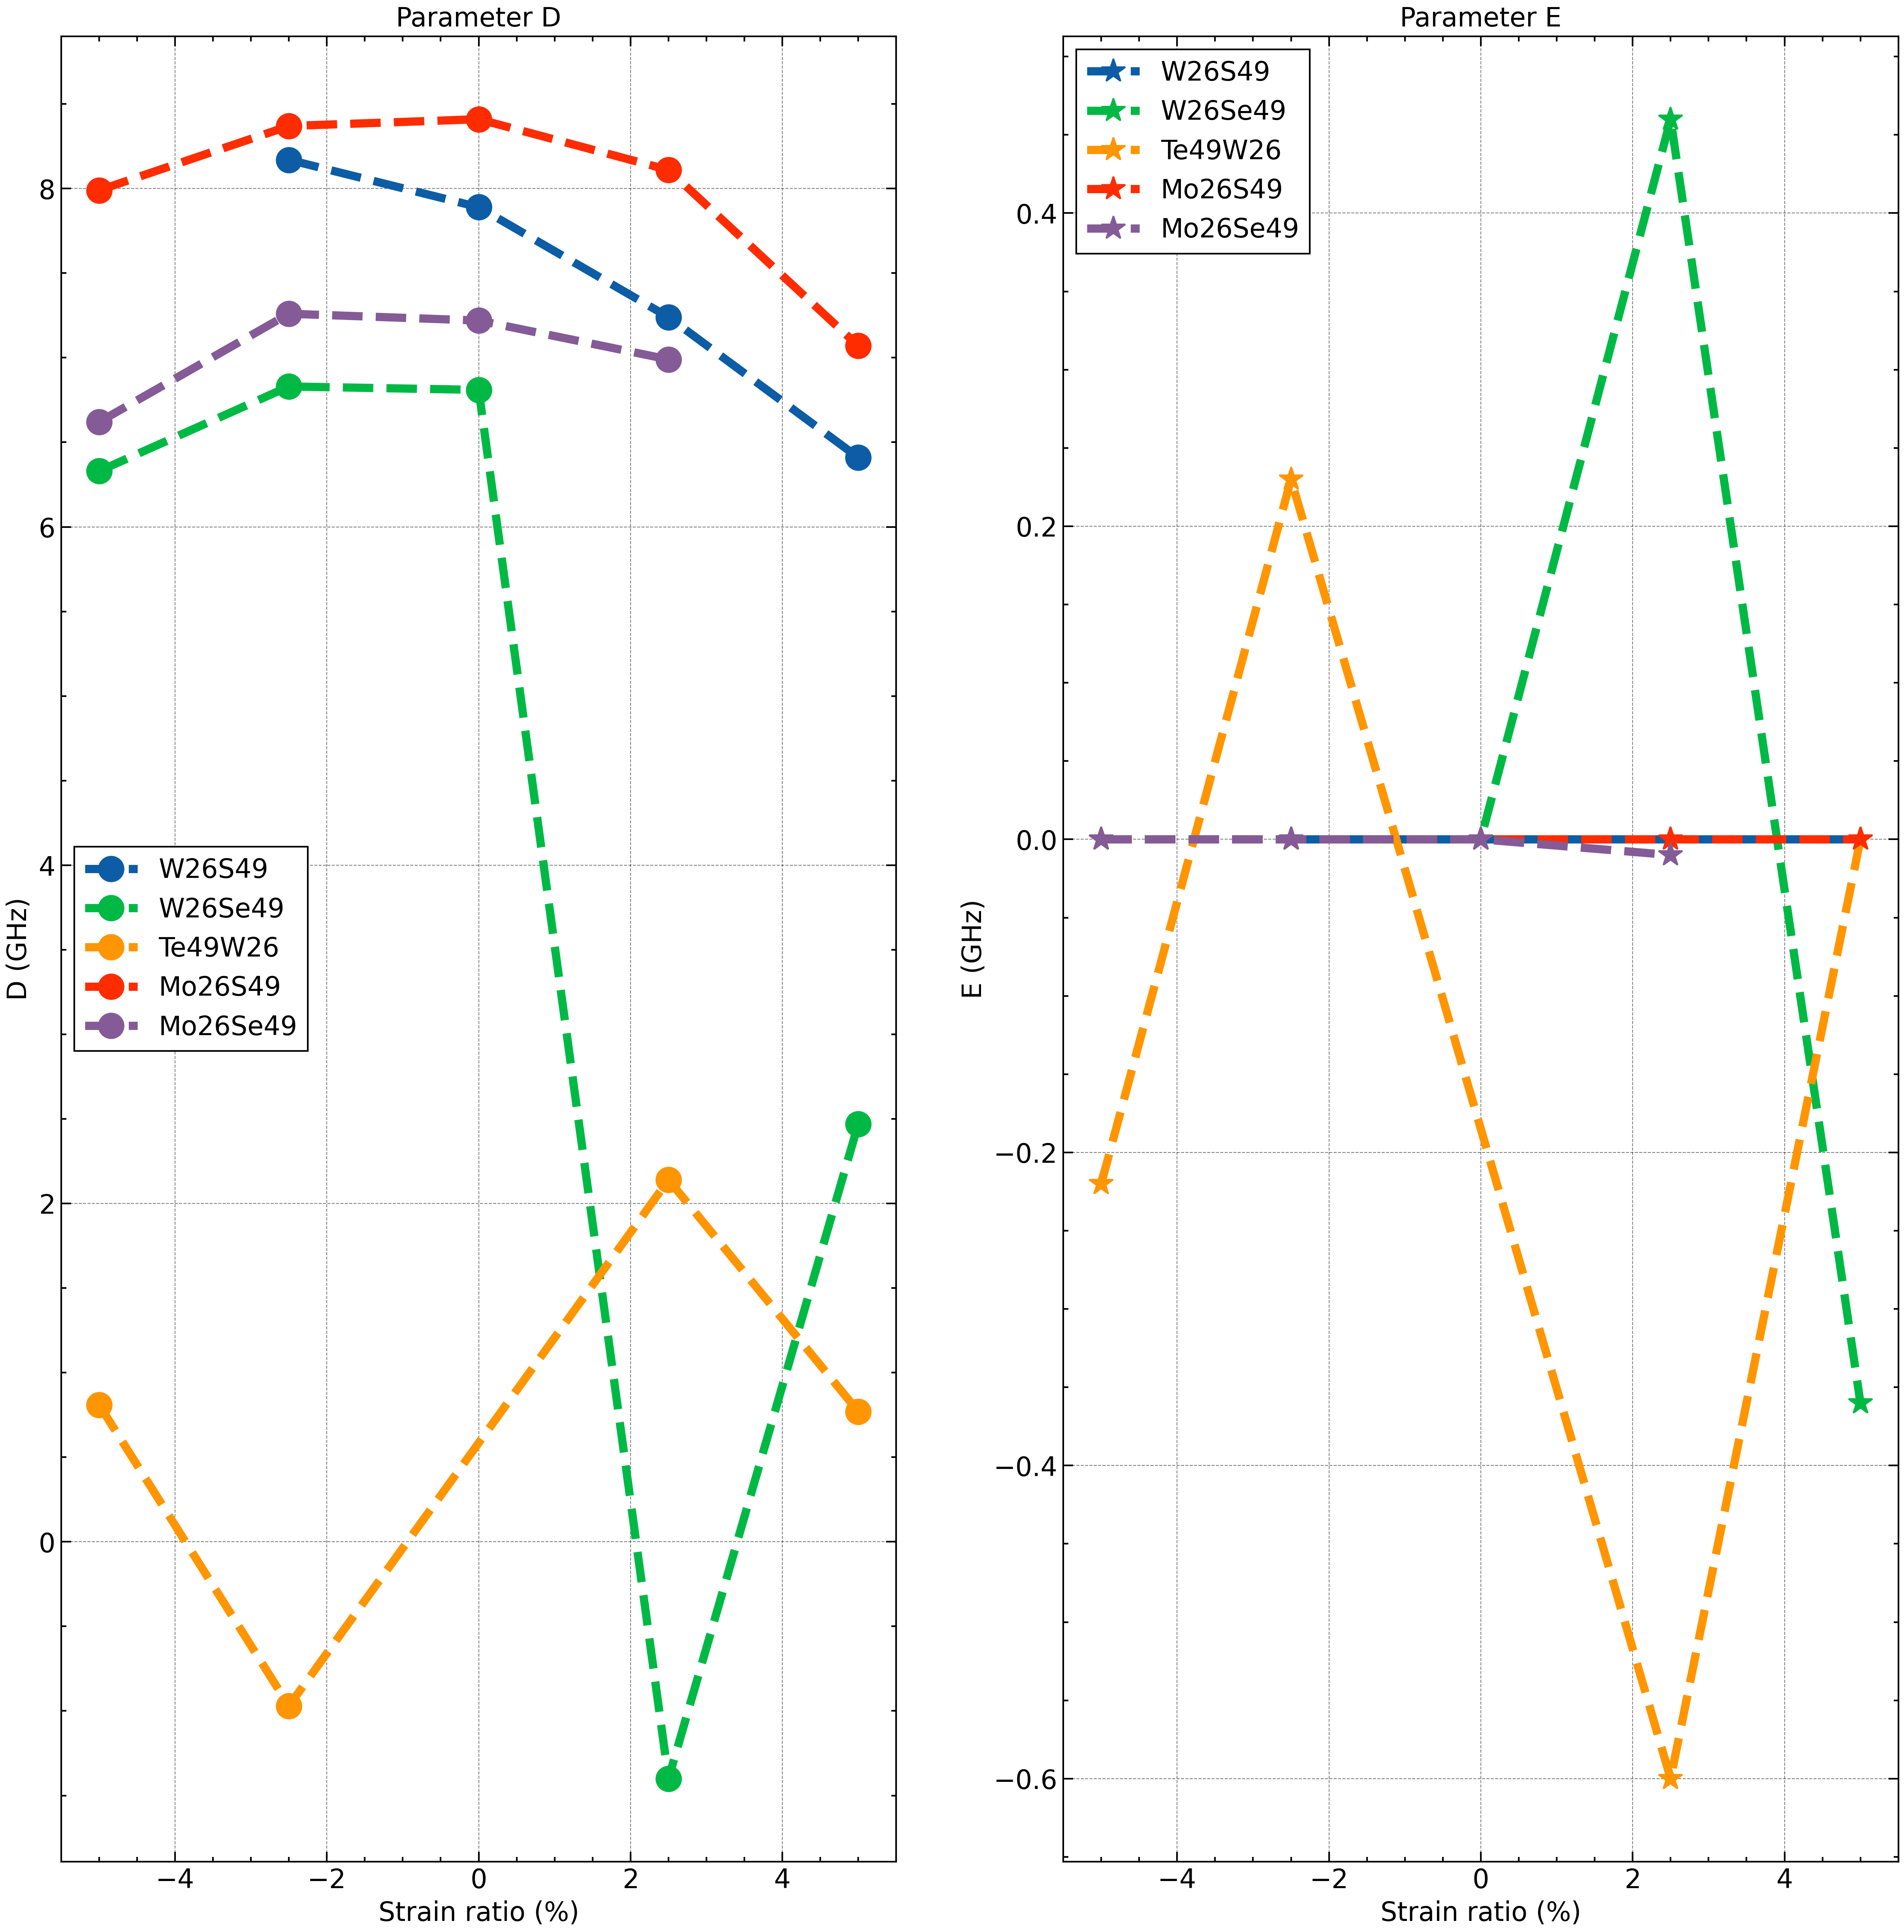

In [9]:
fig = plt.figure(dpi=300, figsize=(20, 20))
# fig.subplots_adjust(hspace=1, wspace=0.4)

for plt_idx, formula in enumerate(zfs_df["formula"].unique()):
    print(formula)
    zfs = zfs_df.loc[zfs_df["formula"] == formula, :]
    zfs0_condition = (zfs0_df["formula"].str.contains(formula)) & (zfs0_df["taskid"] != 815)
    zfs = zfs.append(zfs0_df.loc[zfs0_condition, :]).round(2).sort_values("strain_ratio")
    display(zfs)
    
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(zfs["strain_ratio"], zfs["D"], "o--", label=formula, lw=5, ms=15)
    ax.set_ylabel("D (GHz)")
    ax.legend(loc="center left", fancybox=False, edgecolor="black")
    ax.set_xlabel("Strain ratio (%)")
    ax.set_title("Parameter D")

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(zfs["strain_ratio"], zfs["E"], "*--", label=formula, lw=5, ms=15)
    ax.set_ylabel("E (GHz)")
    ax.legend(fancybox=False, edgecolor="black")
    ax.set_xlabel("Strain ratio (%)")
    ax.set_title("Parameter E")
    
display(fig)

### Structural info

W26S49


,d1,d2,d3,d4,z1,z2,z3,z4,a,b,c,zfs_taskid,scf_taskid,formula,strain_ratio,taskid
1,2.63,2.63,2.63,5.03,1.98,1.98,1.98,1.85,3.07,3.07,4.61,6.0,4.0,W26S49,-2.5,NaN
2,2.63,2.63,2.63,5.13,1.93,1.93,1.93,1.83,3.15,3.15,4.62,NaN,NaN,W26S49,0.0,760.0
0,2.63,2.63,2.63,5.24,1.88,1.88,1.88,1.79,3.23,3.23,4.64,5.0,3.0,W26S49,2.5,NaN
2,2.63,2.63,2.63,5.34,1.81,1.81,1.81,1.74,3.30,3.30,4.65,8.0,7.0,W26S49,5.0,NaN


W26Se49


,d1,d2,d3,d4,z1,z2,z3,z4,a,b,c,zfs_taskid,scf_taskid,formula,strain_ratio,taskid
3,2.62,2.62,2.62,5.07,1.96,1.96,1.96,1.83,3.11,3.11,4.63,17.0,14.0,W26Se49,-5.0,NaN
6,2.62,2.62,2.62,5.18,1.92,1.92,1.92,1.80,3.19,3.19,4.65,20.0,16.0,W26Se49,-2.5,NaN
0,2.62,2.62,2.62,5.29,1.87,1.87,1.87,1.77,3.28,3.28,4.66,NaN,NaN,W26Se49,0.0,758.0
8,2.58,2.58,2.58,5.37,1.65,1.65,1.65,1.59,3.36,3.36,4.68,27.0,25.0,W26Se49,2.5,NaN
9,2.58,2.58,2.58,5.46,1.49,1.49,1.49,1.44,3.44,3.44,4.70,29.0,28.0,W26Se49,5.0,NaN


Te49W26


/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


,d1,d2,d3,d4,z1,z2,z3,z4,a,b,c,zfs_taskid,scf_taskid,formula,strain_ratio,taskid
4,2.53,2.53,2.53,4.16,1.71,1.71,1.71,1.64,3.33,3.33,4.68,18.0,13.0,Te49W26,-5.0,NaN
5,2.54,2.54,2.54,4.22,1.60,1.60,1.60,1.54,3.42,3.42,4.70,19.0,15.0,Te49W26,-2.5,NaN
7,2.58,2.58,2.58,4.26,1.28,1.28,1.28,1.23,3.59,3.59,4.73,23.0,22.0,Te49W26,2.5,NaN
10,2.52,2.52,2.52,4.44,1.06,1.06,1.06,1.01,3.68,3.68,4.75,35.0,32.0,Te49W26,5.0,NaN


Mo26S49


/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


,d1,d2,d3,d4,z1,z2,z3,z4,a,b,c,zfs_taskid,scf_taskid,formula,strain_ratio,taskid
14,2.65,2.65,2.65,4.93,2.04,2.04,2.04,1.90,2.99,2.99,4.59,44.0,41.0,Mo26S49,-5.0,NaN
11,2.66,2.66,2.66,5.03,2.01,2.01,2.01,1.88,3.07,3.07,4.60,38.0,37.0,Mo26S49,-2.5,NaN
3,2.67,2.67,2.67,5.14,1.98,1.98,1.98,1.86,3.15,3.15,4.62,NaN,NaN,Mo26S49,0.0,761.0
15,2.68,2.68,2.68,5.24,1.95,1.95,1.95,1.83,3.23,3.23,4.63,47.0,46.0,Mo26S49,2.5,NaN
16,2.69,2.69,2.69,5.35,1.91,1.91,1.91,1.80,3.30,3.30,4.65,50.0,49.0,Mo26S49,5.0,NaN


Mo26Se49


/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


,d1,d2,d3,d4,z1,z2,z3,z4,a,b,c,zfs_taskid,scf_taskid,formula,strain_ratio,taskid
13,2.65,2.65,2.65,5.09,1.99,1.99,1.99,1.87,3.11,3.11,4.63,43.0,40.0,Mo26Se49,-5.0,NaN
12,2.65,2.65,2.65,5.20,1.96,1.96,1.96,1.84,3.20,3.20,4.64,42.0,39.0,Mo26Se49,-2.5,NaN
1,2.66,2.66,2.66,5.30,1.93,1.93,1.93,1.81,3.28,3.28,4.66,NaN,NaN,Mo26Se49,0.0,759.0
17,2.66,2.66,2.66,5.41,1.88,1.88,1.88,1.76,3.36,3.36,4.68,53.0,52.0,Mo26Se49,2.5,NaN


/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/Users/jeng-yuantsai/anaconda3/envs/workflow/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


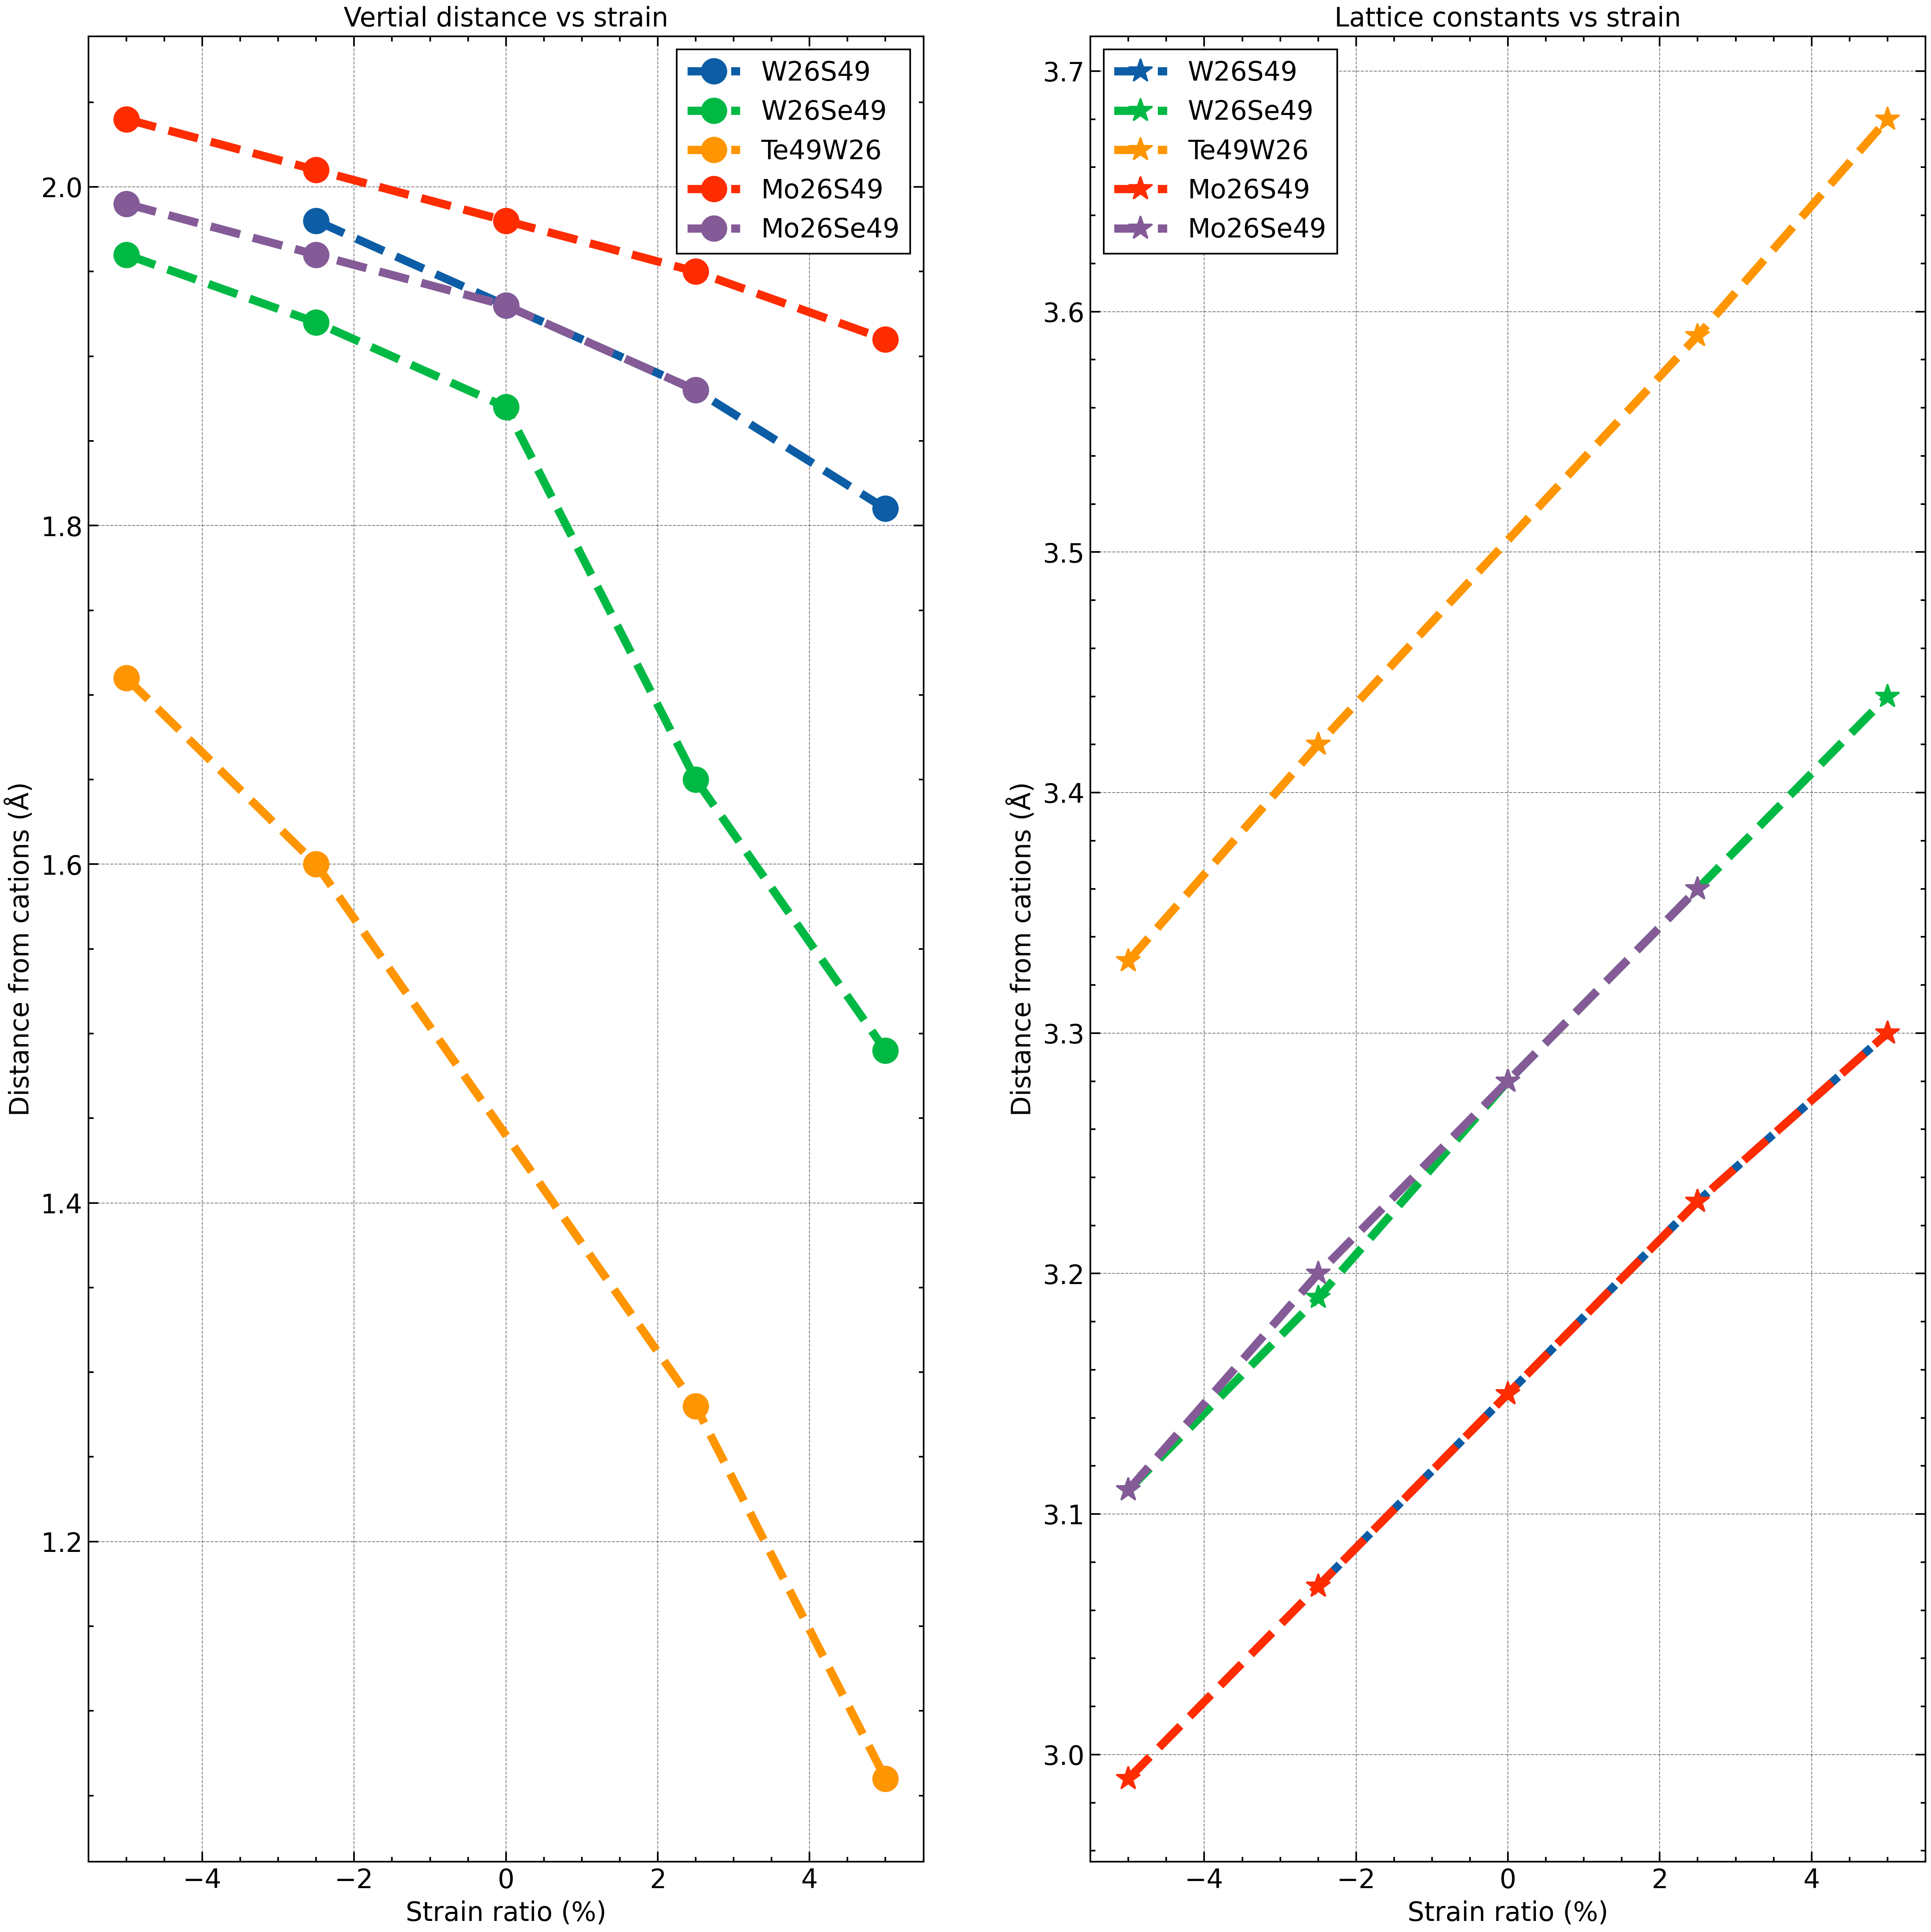

In [10]:
st_data = pd.DataFrame(st_data)
# display(st_data.round(3).sort_values("formula"))
fig = plt.figure(dpi=300, figsize=(20, 20))
for plt_idx, formula in enumerate(st_data["formula"].unique()):
    print(formula)
    
    st_data_df = st_data.loc[st_data["formula"] == formula, :]
    st_condition = (st0_df["formula"].str.contains(formula)) & (st0_df["taskid"] != 815)
    st_data_df = st_data_df.append(st0_df.loc[st_condition, :]).round(2).sort_values("strain_ratio")

    
    st_data_df.sort_values("strain_ratio", inplace=True)
    display(st_data_df)
    
    ax = fig.add_subplot(1, 2, 1)
    ax.set_ylabel("Distance from cations (Å)")
    ax.plot(st_data_df["strain_ratio"], st_data_df["z1"], "o--", label=formula, lw=5, ms=15)

    ax.set_xlabel("Strain ratio (%)")
    ax.set_title("Vertial distance vs strain")
    ax.legend(fancybox=False, edgecolor="black")



    ax = fig.add_subplot(1, 2, 2)
    ax.set_ylabel("Distance from cations (Å)")
    ax.plot(st_data_df["strain_ratio"], st_data_df["a"], "*--", label=formula, lw=5, ms=15)

    ax.set_xlabel("Strain ratio (%)")
    ax.set_title("Lattice constants vs strain")
    ax.legend(fancybox=False, edgecolor="black")



display(fig)